In [ ]:
# default_exp features

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
# stellt sicher, dass beim verändern der core library diese wieder neu geladen wird
%load_ext autoreload
%autoreload 2

# Features

In [ ]:
# imports
from bfh_mt_hs2020_sec_data.core import * 
from pathlib import Path
from typing import List, Tuple, Union, Set

import pandas as pd

import shutil          # provides high level file operations
import time            # used to measure execution time
import os
import sys

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [ ]:
all_data_local_folder = "./data/"

join_group = ["cik","ticker","adsh","period","filed","form","fp"]

## 00_Tools

In [ ]:
def load_data() -> pd.DataFrame:
    df = pd.read_csv(all_data_local_folder + "complete.csv")

    df.period = pd.to_datetime(df.period)
    df.filed = pd.to_datetime(df.filed)
    
    df.sort_values('period', inplace = True)
    df.reset_index(inplace = True)
    return df

## 01_Load

In [ ]:
df = load_data()
print(df.shape)
print((set(df.columns) - set(join_group)))

(94819, 31)
{'PaymentsOfDividendsTotal_hj', 'RetainedEarnings_hj', 'index', 'Equity_hj', 'CashFromFinancing', 'CashFromInvesting', 'NetIncomeLoss', 'NetIncomeLoss_hj', 'CashFromOperating', 'cf_qtrs', 'PaymentsForRepurchaseOfStockTotal_hj', 'AssetsCurrent', 'Assets', 'CashIncreaseDecrease_hj', 'Revenues_hj', 'GrossProfit', 'OperatingIncomeLoss_hj', 'LiabilitiesNoncurrent', 'AssetsNoncurrent', 'bs_qtrs', 'Liabilities', 'is_qtrs', 'ProfitLoss', 'LiabilitiesCurrent'}


## 02_Basic Features

In [ ]:
df['period_day_of_week']   = df.period.dt.dayofweek
df['period_day_of_month']  = df.period.dt.day
df['period_day_of_year']   = df.period.dt.dayofyear
df['period_week_of_year']  = df.period.dt.weekofyear
df['period_month_of_year'] = df.period.dt.month

## 03_In-report Ratios Features

Contains features, that are created based on the data inside a single report.

**BalanceSheet Ratios**
- WorkingCapitalToAssets = (CurrentAssets - CurrentLiabilities) / CurrentAssets
- CurrentRatio = CurrentAssets / CurrentLiabilities
- DebtToEquity = Liabilities / Equity
- DebtRatio = TotalLiabilities/TotalAssets
- _QuickRatio = (CurrentAssets - Inventory)/CurrentLiabilities_


**IncomeStatement Ratios**
- NetProfitMargin  = GrossProfit / Revenues
- OperatingMargin  = OperatingIncome / Revenues
- NetIncomeMargin  = NetIncome / Revenues 


**Cashflow Ratios**
- CashGeneratingPowerRatio = CashFromOperations / (CashFromOperations + CashFromFinancing + CashFromInvesting)
- ExternalFinancingIndexRatio = CashFromFinancing / CashFromOperations)


**IncomeStatment / BalanceSheet**
- ReturnOnEquity = NetIncome / (Average) Equity 
- ReturnOnAssets = NetIncome / TotalAssets
- AssetsTurnoverRatio = NetSales / TotalAssets

(Variation: NetIncome: use TTM NetIncome -> NetIncome during the last 12 months)
(Variation: Total Assets: Use average of Assets over the period)


**IncomeStatement / CashFlow**
- Dividend Payout Ratio = DividendsPaid / NetIncome
- StockRepurchaseRatio = PaymentsForStockRepurchase / NetIncome 
- Operating Cash Flow Ratio = CashFromOperations / Revenue


**BalanceSheet / CashFlow**
- AssetEfficiencyRatio = CashFromOperations / Assets
- CurrentLiabilityCoverageRatio = (CashFromOperations - DividendsPaid)/CurrentLiabilities
- LongTermDebtCoverageRatio = (CashFromOperations - DividendsPaid)/NonCurrentLiabilities


**Share related Ratios**
- _PERatio = SharePrice / EarningsPerShare_
- _PEGRatio (Price/Earnings-to-Growth) = PERatio / EPS Growth_
- _PBRatio (PriceToBook) = SharePrice / Equity per share_
- _DividendYield = Dividend per Share / SharePrice_


### BalanceSheet Ratios

In [ ]:
# WorkingCapitalToAssets = (CurrentAssets - CurrentLiabilities) / CurrentAssets
df['r_workcapToAssets'] = (df.AssetsCurrent - df.LiabilitiesCurrent) / df.AssetsCurrent

# CurrentRatio = CurrentAssets / CurrentLiabilities
df['r_currentRatio']  = df.AssetsCurrent / df.LiabilitiesCurrent

# DebtToEquity = Liabilities / Equity
df['r_deptToEquity']  = df.Liabilities / df.Equity_hj

# DebtRatio = TotalLiabilities/TotalAssets
df['r_deptRatio']  = df.Liabilities / df.Assets

### IncomeStatement Ratios

In [ ]:
# NetProfitMargin  = GrossProfit / Revenues
df['r_netProfitMargin'] = df.GrossProfit / df.Revenues_hj

# OperatingMargin  = OperatingIncome / Revenues
df['r_operatingMargin'] = df.OperatingIncomeLoss_hj / df.Revenues_hj

# NetIncomeMargin  = NetIncome / Revenues 
df['r_netIncomeMargin'] = df.NetIncomeLoss_hj / df.Revenues_hj

### CashFlow Ratios

In [ ]:
# CashGeneratingPowerRatio = CashFromOperations / (CashFromOperations + CashFromFinancing + CashFromInvesting)
df['r_cashGenPowerRatio'] = df.CashFromOperating / (df.CashFromOperating + df.CashFromFinancing + df.CashFromInvesting)

# ExternalFinancingIndexRatio = CashFromFinancing / CashFromOperations)
df['r_extFinancingIndexRatio'] = df.CashFromFinancing / df.CashFromOperating

### IncomeStatment / BalanceSheet Ratios

In [ ]:
# ReturnOnEquity = NetIncome / (Average) Equity 
df['r_returnOnEquity'] = df.NetIncomeLoss_hj / df.Equity_hj

# ReturnOnAssets = NetIncome / TotalAssets
df['r_returnOnAssets'] = df.NetIncomeLoss_hj / df.Assets

# AssetsTurnoverRatio = NetSales / TotalAssets
df['r_assetsTurnoverRatio'] = df.Revenues_hj / df.Assets 

### IncomeStatement / CashFlow

In [ ]:
# Dividend Payout Ratio = DividendsPaid / NetIncome
df['r_dividendPayoutRatio'] = df.PaymentsOfDividendsTotal_hj / df.NetIncomeLoss_hj

# StockRepurchaseRatio = PaymentsForStockRepurchase / NetIncome 
df['r_stockRepurchaseRatio'] = df.PaymentsForRepurchaseOfStockTotal_hj / df.NetIncomeLoss_hj

# Operating Cash Flow Ratio = CashFromOperations / Revenue
df['r_operatingCashFlowRatio'] = df.CashFromOperating / df.Revenues_hj

### BalanceSheet / CashFlow

In [ ]:
# AssetEfficiencyRatio = CashFromOperations / Assets
df['r_assetEfficiencyRatio'] = df.CashFromOperating / df.Assets 

# CurrentLiabilityCoverageRatio = (CashFromOperations - DividendsPaid) / CurrentLiabilities
df['r_currentLiabCoverageRatio'] = (df.CashFromOperating - df.PaymentsOfDividendsTotal_hj) / df.LiabilitiesCurrent  

# LongTermDebtCoverageRatio = (CashFromOperations - DividendsPaid) / NonCurrentLiabilities
df['r_longtermDeptCoverageRatio']  =  (df.CashFromOperating - df.PaymentsOfDividendsTotal_hj) / df.LiabilitiesNoncurrent

### Save

In [ ]:
df.to_csv(all_data_local_folder + "features_ratios.csv", index=False)

## 04_Increase/Decrease Features - "Change Ratios"

The growthrate of an attribute is defined by <br>
(newValue - lastValue) / lastValue

For instance: lastYearsRevenue = 10 Mio, thisYearRevenue = 20 Mio => (20 - 10) / 10 = 2

But we have distinguish if "lastValue" was negativ.<p>
For instance: lastYearsRevenue = -10 Mio, thisYearRevenue = -20 Mio => (-20 - -10) / -10 => (-20 + 10) / -10 = 2<br>
Would also equals to 2.0, as in the example with 20Mio and 10Mio
<p>
Therefore, for every "growthrate"-feature two features will be created. The first one ends with "_p" and contains the value when the "lastValue" was > 0 and the second names with "_n" and contains the results when "lastValue" was < 0.

This is done based on the Quater, so Q1 data are compared with the last Q1, Q2 with the last Q2, Q3 with the last Q3 and FY with the last FY. 

Growth-Rates for the following positions will be calculated:
<br>
**BalanceSheet GrowthRatios for**
- AssetsCurrent
- AssetsNoncurrent
- LiabilitiesCurrent
- LiabilitiesNoncurrent
- Equity_hj
    
**IncomeStatement GrowthRatios for**  
- Revenues_hj
- GrossProfit
- OperatingIncomeLoss_hj
- NetIncomeLoss_hj
- RetainedEarnings_hj

**CashflowStatement GrowthRatios for**
- CashFromInvesting
- CashFromFinancing
- CashFromOperating
- PaymentsOfDividendsTotal_hj



In [ ]:
def calculate_growth(all_df: pd.DataFrame, grouped_df: pd.DataFrame, data_cols:List[str], new_cols_prefix:List[str]):
    
    for data_col, new_col_prefix in zip(data_cols, new_cols_prefix):
        col_name_p = new_col_prefix + "_p"
        col_name_n = new_col_prefix + "_n"
        
        all_df.loc[grouped_df.index[0], col_name_p] = 1.0
        all_df.loc[grouped_df.index[0], col_name_n] = 0.0
    
        is_positiv_arr = (grouped_df[data_col] > 0.0).to_numpy()
        is_negativ_arr = (grouped_df[data_col] < 0.0).to_numpy()
        data_arr = all_df.loc[grouped_df.index, data_col].to_numpy()
        
        change_arr = ((data_arr[1:] - data_arr[:-1]) / data_arr[:-1])

        all_df.loc[grouped_df.index[1:], col_name_p] =  is_positiv_arr[:-1] * change_arr
        all_df.loc[grouped_df.index[1:], col_name_n] =  is_negativ_arr[:-1] * change_arr

In [ ]:
list_data_cols = ['Revenues_hj', 'GrossProfit', 'OperatingIncomeLoss_hj', 'NetIncomeLoss_hj', 'RetainedEarnings_hj', 'Equity_hj']
list_new_cols  = ['gr_revenue' , 'gr_grosspr' , 'gr_opiincome',           'gr_netincome',     'gr_earnings',         'gr_equity']

list_data_cols.extend(['AssetsCurrent', 'AssetsNoncurrent', 'LiabilitiesCurrent', 'LiabilitiesNoncurrent'])
list_new_cols.extend( ['gr_asscur',     'gr_assnoncur',     'gr_liabcur',         'gr_liabnoncur'        ])

list_data_cols.extend(['CashFromInvesting', 'CashFromFinancing', 'CashFromOperating', 'PaymentsOfDividendsTotal_hj'])
list_new_cols.extend( ['gr_cashfrominv',    'gr_cashfromfin',    'gr_cashfromope',    'gr_dividends'])

In [ ]:
# multiprocessing is not really working in jupyter on windows
# therfore there ist the 07_features_growth.py skript, which which enables multiprocessing

start = time.time()
for ticker, entry in df.groupby(['cik', 'fp']):
    print('.',end="")
    calculate_growth(df, entry, list_data_cols, list_new_cols)
print("duration: ", time.time() - start)

### Save

In [ ]:
df.to_csv(all_data_local_folder + "features_all.csv", index=False)

## XX_Trials

In [ ]:
#df[df.ticker == 'AAPL'].sort_values('period')[['adsh','period', 'period_year','fp','bs_qtrs','is_qtrs','cf_qtrs','CashFromOperating','CashFromFinancing','CashFromInvesting','RetainedEarnings_hj']]
df[df.ticker == 'AAPL'].sort_values('period')[['period', 'period_year','fp','Revenues_hj','CashFromOperating','CashFromFinancing','CashFromInvesting','RetainedEarnings_hj']]

,period,period_year,fp,Revenues_hj,CashFromOperating,CashFromFinancing,CashFromInvesting,RetainedEarnings_hj
91201,2012-03-31,2012,Q2,3.918600e+10,3.153100e+10,3.790000e+08,-3.160400e+10,8.712400e+10
17177,2012-06-30,2012,Q3,3.502300e+10,4.172000e+10,3.240000e+08,-4.391400e+10,9.564100e+10
87974,2012-09-30,2012,FY,1.565080e+11,5.085600e+10,-1.698000e+09,-4.822700e+10,1.012890e+11
83302,2012-12-31,2012,Q1,5.451200e+10,2.342600e+10,-4.497000e+09,-1.352100e+10,1.095670e+11
81220,2013-03-31,2013,Q2,4.360300e+10,3.593000e+10,-6.745000e+09,-2.787800e+10,1.165720e+11
25646,2013-06-30,2013,Q3,3.532300e+10,4.375800e+10,-8.871000e+09,-3.438500e+10,1.045640e+11
11380,2013-09-30,2013,FY,1.709100e+11,5.366600e+10,-1.637900e+10,-3.377400e+10,1.042560e+11
47724,2013-12-31,2013,Q1,5.759400e+10,2.267000e+10,-7.749000e+09,-1.510300e+10,1.094310e+11
48452,2014-03-31,2014,Q2,4.564600e+10,3.620800e+10,-2.815600e+10,-3.362000e+09,9.893400e+10
41986,2014-06-30,2014,Q3,3.743200e+10,4.646300e+10,-2.216900e+10,-2.557600e+10,9.871500e+10


<AxesSubplot:xlabel='period'>

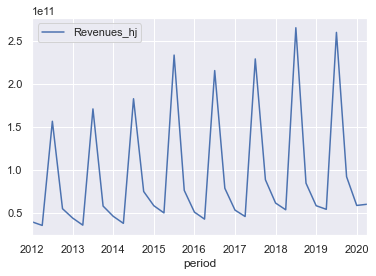

In [ ]:
df[df.ticker == 'AAPL'].sort_values('period')[['Revenues_hj', 'period']].set_index('period').plot()

In [ ]:
test_df = df[df.ticker.isin(['AAPL','INTC'])].sort_values('period').copy().reset_index()
test_df[:15]

,index,cik,ticker,adsh,period,filed,form,bs_qtrs,fp,Assets,...,r_returnOnAssets,r_assetsTurnoverRatio,r_dividendPayoutRatio,r_stockRepurchaseRatio,r_operatingCashFlowRatio,r_assetEfficiencyRatio,r_currentLiabCoverageRatio,r_longtermDeptCoverageRatio,period_year,period_month
0,91201,320193,AAPL,0001193125-12-182321,2012-03-31,2012-04-25,10-Q,0.0,Q2,1.509340e+11,...,0.077001,0.259623,0.000000,0.000000,0.804650,0.208906,0.984236,1.922622,2012,2012-03
1,6675,50863,INTC,0001193125-12-212253,2012-03-31,2012-05-04,10-Q,0.0,Q1,7.181700e+10,...,0.038125,0.179707,0.383126,0.554785,0.230280,0.041383,0.161042,inf,2012,2012-03
2,32844,50863,INTC,0001193125-12-329132,2012-06-30,2012-08-01,10-Q,0.0,Q2,7.235200e+10,...,0.039073,0.186602,0.744959,1.031128,0.571143,0.106576,0.531885,inf,2012,2012-06
3,17177,320193,AAPL,0001193125-12-314552,2012-06-30,2012-07-25,10-Q,0.0,Q3,1.628960e+11,...,0.054170,0.215002,0.000000,0.000000,1.191217,0.256114,1.261948,2.306247,2012,2012-06
4,87974,320193,AAPL,0001193125-12-444068,2012-09-30,2012-10-31,10-K,0.0,FY,1.760640e+11,...,0.237033,0.888927,0.000000,0.000000,0.324942,0.288850,1.319496,2.633389,2012,2012-09
5,14308,50863,INTC,0001193125-12-444095,2012-09-30,2012-10-31,10-Q,0.0,Q3,7.444100e+10,...,0.039924,0.180774,1.087147,1.376178,0.955488,0.172727,0.805405,inf,2012,2012-09
6,83302,320193,AAPL,0001193125-13-022339,2012-12-31,2013-01-24,10-Q,0.0,Q1,1.960880e+11,...,0.066695,0.277998,0.000000,0.149105,0.429740,0.119467,0.499712,1.071491,2012,2012-12
7,20567,50863,INTC,0001193125-13-065416,2012-12-31,2013-02-19,10-K,0.0,FY,8.435100e+10,...,0.130467,0.632370,0.395275,0.464334,0.354024,0.223874,1.126841,inf,2012,2012-12
8,58808,50863,INTC,0000050863-13-000043,2013-03-31,2013-04-29,10-Q,0.0,Q1,8.308300e+10,...,0.024614,0.151415,0.544743,0.273350,0.340620,0.051575,0.268774,inf,2013,2013-03
9,81220,320193,AAPL,0001193125-13-168288,2013-03-31,2013-04-24,10-Q,0.0,Q2,1.947430e+11,...,0.049024,0.223900,0.000000,0.204253,0.824026,0.184500,1.011885,1.513161,2013,2013-03


In [ ]:
df_sample = pd.DataFrame({'A' :  ['AAPL',  'AAPL', 'AAPL', 'AAPL', 'INTC',  'INTC',   'INTC'],
                          'B' :  ['Q1',    'Q2',   'Q3',    'Q4',  'Q1',    'Q2',     'Q3'],
                          'C' :  [ 1.0,    -1.0,    -2.0,   2.0,   1.0,      2.0,       3.0] \
                  })

In [ ]:

for ticker, entry in df_sample.groupby(['A']):
    print(ticker, " ", entry.shape)

    df_sample.loc[entry.index[0], 'D1'] = 1.0
    df_sample.loc[entry.index[0], 'D2'] = 0.0
        
    pos_arr = (entry['C'] > 0.0).to_numpy()
    arr = df_sample.loc[entry.index, 'C'].to_numpy()
    
    df_sample.loc[entry.index[1:], 'D1'] = pos_arr[:-1] * ((arr[1:] - arr[:-1]) / arr[:-1])
    df_sample.loc[entry.index[1:], 'D2'] = (pos_arr[:-1] == False) * ((arr[1:] - arr[:-1]) / arr[:-1])
        
    print("", end = "\n\n")
    
df_sample.sort_values('A')

AAPL   (4, 3)
[ True False False  True]


INTC   (3, 3)
[ True  True  True]




,A,B,C,D1,D2
0,AAPL,Q1,1.0,1.0,0.0
1,AAPL,Q2,-1.0,-2.0,-0.0
2,AAPL,Q3,-2.0,0.0,1.0
3,AAPL,Q4,2.0,-0.0,-2.0
4,INTC,Q1,1.0,1.0,0.0
5,INTC,Q2,2.0,1.0,0.0
6,INTC,Q3,3.0,0.5,0.0


In [ ]:
def func(x):
    print(type(x))
    if type(x) == pd.DataFrame:
        print("yes: ", x.columns)
        x.C = x.C[1:] / x.C[:-1]
        x.C[0] = 1.0
        
    print('-------')
    return x

In [ ]:
df_sample.groupby(['A']).transform(func)

<class 'pandas.core.series.Series'>
-------
<class 'pandas.core.series.Series'>
-------
<class 'pandas.core.series.Series'>
-------
<class 'pandas.core.frame.DataFrame'>
yes:  Index(['B', 'C'], dtype='object')
-------
<class 'pandas.core.series.Series'>
-------
<class 'pandas.core.series.Series'>
-------
<class 'pandas.core.series.Series'>
-------


C:\ieu\Anaconda3\envs\spark\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\ieu\Anaconda3\envs\spark\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ieu\Anaconda3\envs\spark\lib\site-packages\pandas\core\groupby\generic.py:1474: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

,B,C
0,Q1,1.0
1,Q1,1.0
2,Q2,3.0
3,Q2,2.0
4,Q3,5.0
5,Q3,3.0


In [ ]:
c = df_sample.C
c

0    1.0
1    1.0
2    3.0
3    2.0
4    5.0
5    3.0
Name: C, dtype: float64

In [ ]:
c[1:].array / c[:-1].array

<PandasArray>
[1.0, 3.0, 0.6666666666666666, 2.5, 0.6]
Length: 5, dtype: float64

In [ ]:
np_arr = c.array
print(np_arr)
np_arr[1:] = np_arr[1:] / np_arr[:-1]
np_arr[0] = 1.0
print(np_arr)

<PandasArray>
[1.0, 1.0, 3.0, 2.0, 5.0, 3.0]
Length: 6, dtype: float64
<PandasArray>
[1.0, 1.0, 3.0, 0.6666666666666666, 2.5, 0.6]
Length: 6, dtype: float64


In [ ]:
c

0    1.000000
1    1.000000
2    3.000000
3    0.666667
4    2.500000
5    0.600000
Name: C, dtype: float64